# Some attempt at Particle Tracking

In [155]:
# Importing things

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.fft import rfft, rfftfreq

from lab_functions import *

In [156]:
# where is the data?
loc = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/Memory Stick Backup/2024-03-11/'
filename = 'Results.csv'

# read in as dataframe
df = pd.read_csv(loc + filename)

# select x and y positions of bead for all 83 frames
# get rid of anomalous last point
x = np.array(df['x'])[:-1]
y = np.array(df['y'])[:-1]

In [157]:
# Conversion Factor
pixels_microns = 15.36
pm_err = 0.5

x_mic = x*(1/pixels_microns)
y_mic = y*(1/pixels_microns)

x_mic_err = np.abs(x*(1/(pixels_microns+pm_err)) - x*(1/pixels_microns))
y_mic_err = np.abs(y*(1/(pixels_microns+pm_err)) - y*(1/pixels_microns))

Text(0, 0.5, 'y / Microns')

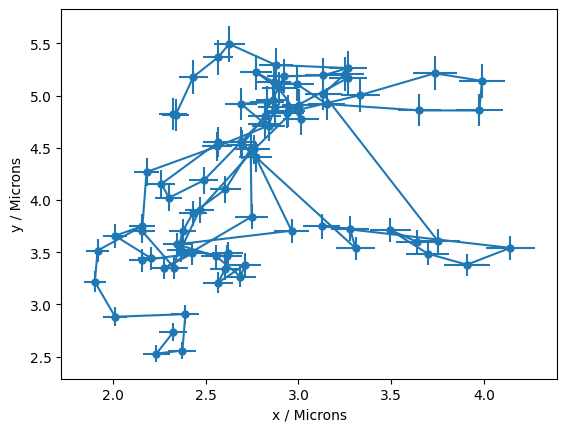

In [158]:
# Plot x and y trajectory

plt.errorbar(x_mic,y_mic, yerr = y_mic_err, xerr = x_mic_err, ms = 5, fmt = 'o', linestyle = '-')
plt.xlabel('x / Microns')
plt.ylabel('y / Microns')

Text(0, 0.5, 'Position / Microns')

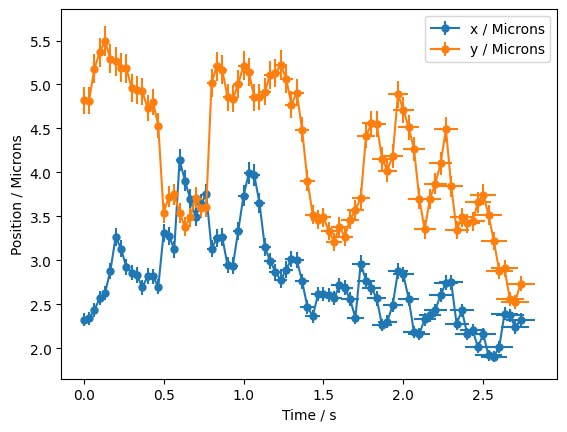

In [159]:
# Frames per second on camera
fps = 30
fps_err = 1

# Set time axis in seconds
time = np.arange(x.size) / 30
time_err = np.arange(x.size) * np.abs(1/31 - 1/30) # fps error is 1

# plot x and y over time
plt.errorbar(time,x_mic, xerr = time_err, yerr = x_mic_err, ms = 5, fmt = 'o', linestyle = '-', label = 'x / Microns')
plt.errorbar(time,y_mic, xerr = time_err, yerr = y_mic_err, ms = 5, fmt = 'o', linestyle = '-', label = 'y / Microns')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Position / Microns')

Text(0, 0.5, 'Position around zero / Microns')

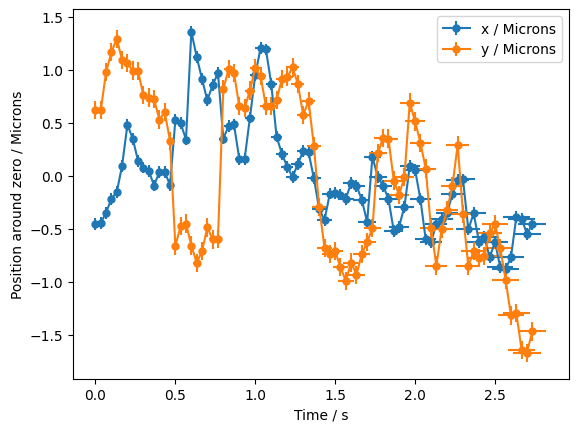

In [160]:
# Find mean of particle tracks to centre data on zero
x_mean = np.mean(x_mic)
y_mean = np.mean(y_mic)

# Error on mean = standard error
x_stderr = np.std(x_mic) / np.sqrt(len(x_mic))
y_stderr = np.std(y_mic) / np.sqrt(len(y_mic))

# Subtract mean from data
x_mic0 = x_mic - x_mean
y_mic0 = y_mic - y_mean

# Errors
x_mic0_err = np.abs( (x_mic - (x_mean+x_stderr)) - (x_mic - x_mean) )
y_mic0_err = np.abs( (y_mic - (y_mean+y_stderr)) - (y_mic - y_mean) )

# plot x and y over time
plt.errorbar(time,x_mic0, xerr = time_err, yerr = x_mic0_err, ms = 5, fmt = 'o', linestyle = '-', label = 'x / Microns')
plt.errorbar(time,y_mic0, xerr = time_err, yerr = y_mic0_err, ms = 5, fmt = 'o', linestyle = '-', label = 'y / Microns')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Position around zero / Microns')

Text(0, 0.5, 'Fourier Transform Squared / Arb Units')

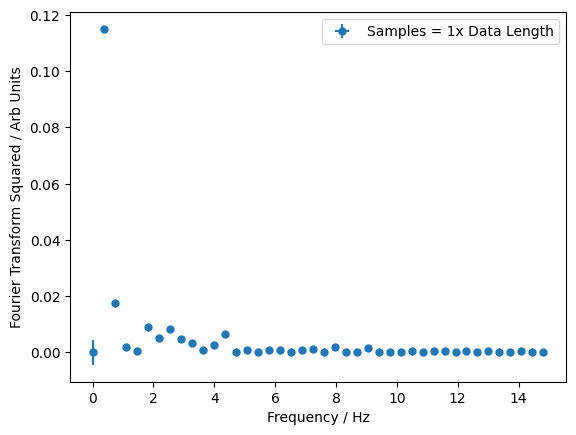

In [161]:
def fourier_calc(data, sample_number):

    # Compute transform and normalise by length / 2
    fast_four = rfft(data, n = sample_number) / (len(data) / 2)

    # Compute amplitude squared and divide by measurement time
    ps = np.abs(fast_four)**2 / time[-1]

    # Calculate frequency components (is the sample spacing right?)
    freq = rfftfreq(sample_number, d=1.0/fps)

    return ps, freq

ps, freq = fourier_calc(x_mic0, x_mic0.size)

# Errors
psplus, freqplus = fourier_calc(x_mic0+x_mic0_err, x_mic0.size)
ps_err = np.abs(psplus - ps) # mostly tiny
freq_err = np.abs(freqplus - freq) # all zero

# Plot using above function
plt.errorbar(freq, ps, xerr = freq_err, yerr = ps_err, ms = 5, fmt = 'o', linestyle = '',label = 'Samples = {}x Data Length'.format(1))
plt.legend()
plt.xlabel('Frequency / Hz')
plt.ylabel('Fourier Transform Squared / Arb Units')

C:\Users\abiga\AppData\Local\Temp\ipykernel_19968\3499516701.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-8,0)


(1e-08, 3.9873373128072704)

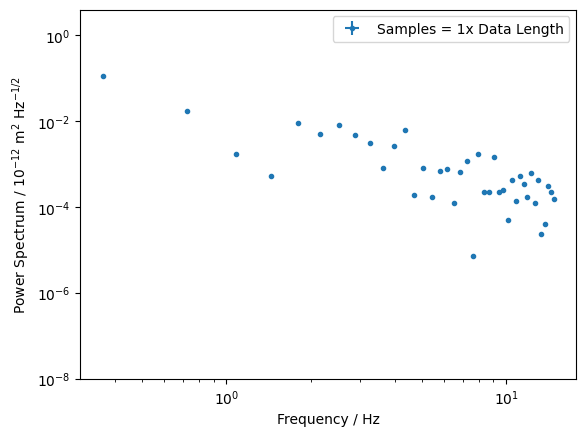

In [162]:
# Error on power spectrum - replace zeros

for i in range(len(ps_err)):
    if ps_err[i] == 0.0:
        ps_err[i] = 1e-30  # much smaller than other errors - basically zero

# Use a log scale
plt.errorbar(freq, ps, xerr = freq_err, yerr = ps_err, label = 'Samples = {}x Data Length'.format(1), linestyle = '', marker = 'o', ms = 3)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Frequency / Hz')
plt.ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')
plt.ylim(1e-8,0)

In [163]:
# Fit the above to Lorenzian Power Spectrum

def Lorentzian(x,A,f_0):
    return A / ((1 + x/f_0)**2)

ig = np.array([0.12,0.1])

# Fits to no padding and padding in fft
''' WARNING: Arb error here. Needs work '''
yfit, parameters, perrors, chisq_reduced, p_value, dof = fit_labs(freq,ps,0.1,Lorentzian,ig)

C:\Users\abiga\AppData\Local\Temp\ipykernel_19968\2190128095.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim(1e-8,0)


The Amplitude of the Lorentzian is 0.040893691758267375 10^-12 m$^2$ Hz^-1/2$
The Cutoff Frequency is 2.160667252205341 Hz
The reduced chi squared value for the fit is 0.023912795596090088


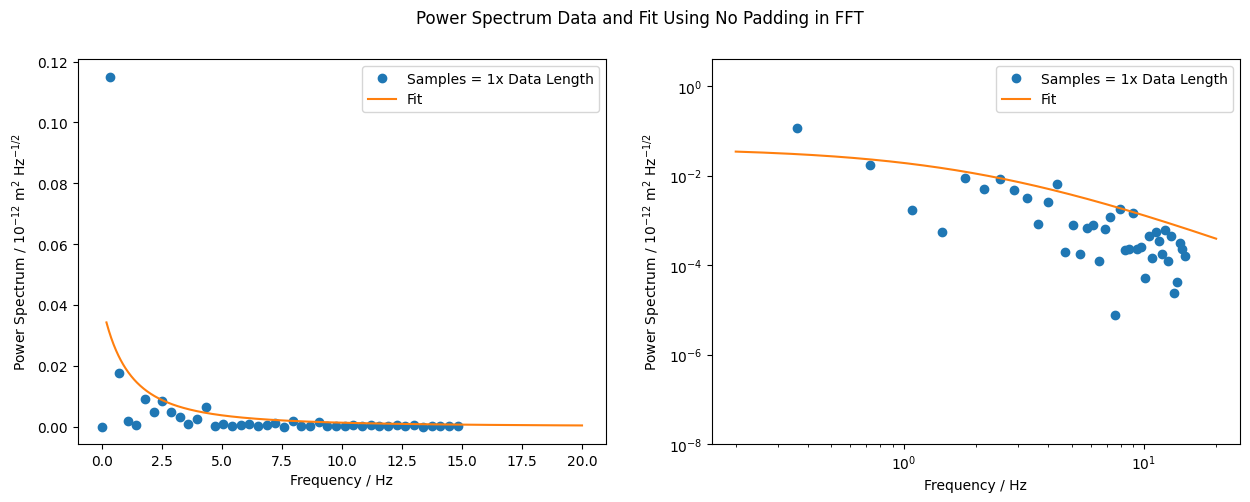

In [164]:
# Plot with Fit
# Use a log scale

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,5))

some_fs = np.linspace(0.2,20,1000)

fig.suptitle('Power Spectrum Data and Fit Using No Padding in FFT')

# Axis 1 - normal scale
ax1.plot(freq, ps, label = 'Samples = {}x Data Length'.format(1), linestyle = '', marker = 'o')
ax1.plot(some_fs, Lorentzian(some_fs,parameters[0],parameters[1]), label = 'Fit', linestyle = '-')
ax1.legend()
ax1.set_xlabel('Frequency / Hz')
ax1.set_ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')

# Axis 2 - log scale
ax2.loglog(freq, ps, label = 'Samples = {}x Data Length'.format(1), linestyle = '', marker = 'o')
ax2.loglog(some_fs, Lorentzian(some_fs,parameters[0],parameters[1]), label = 'Fit', linestyle = '-')
ax2.legend()
ax2.set_xlabel('Frequency / Hz')
ax2.set_ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')
ax2.set_ylim(1e-8,0)

print('The Amplitude of the Lorentzian is {} 10^-12 m$^2$ Hz^-1/2$'.format(parameters[0]))
print('The Cutoff Frequency is {} Hz'.format(parameters[1]))
print('The reduced chi squared value for the fit is {}'.format(chisq_reduced))

In [165]:
# Calculate the key parameters

# ROUGHLY 1.5 centi Poise 
# https://corecheminc.com/ethylene-glycol-water-mixture-properties/
eta = 1.5e-3 # Pa s
eta_err = 0.1e-3

# Radius of Beads
radius = 2.56e-6 / 2 # in microns
radius_err = 0.01e-6 / 2

# Boltzmanns const
k_b = 1.38e-23
# Temperature
T = 273+25

# Caclulate stokes drag constant
beta = 6*np.pi*eta*radius

# Use cutoff freq to find stiffness constant, kappa
f0 = parameters[1]
stiffness = 2*np.pi*beta*f0

print('The Stiffness Constant is k = {} N m^-1'.format(stiffness))

The Stiffness Constant is k = 4.913264107389424e-07 N m^-1


In [166]:
# Trapping Force - kx

''' Use standard deviation as delta x?'''
delta_x = np.std(x_mic0) * 1e-6 # CONVERT TO METRES
force = stiffness*delta_x
print('The force is {} pN'.format(force*1e12))

The force is 0.2485108605038943 pN


In [167]:
# F = QnP / c
# so Q = Fc / nP

power = 1e-3 # in watts
n = 1.38805 # see https://pubs.acs.org/doi/10.1021/je900630n 
c = 3e8

Q = force*c / n*power

print('The Trapping Efficiency Q is {}'.format(Q))
print('With error included, this is essentially zero')

The Trapping Efficiency Q is 5.371078718430049e-08
With error included, this is essentially zero
